# Import Library

In [ ]:
pip install sastrawi

In [ ]:
import pandas as pd
import numpy as np  # NumPy untuk komputasi numerik
import tensorflow as tf
import matplotlib.pyplot as plt  # Matplotlib untuk visualisasi data
import seaborn as sns  # Seaborn untuk visualisasi data statistik, mengatur gaya visualisasi
from sklearn.metrics import accuracy_score

import re  # Modul untuk bekerja dengan ekspresi reguler
import string  # Berisi konstanta string, seperti tanda baca
from nltk.tokenize import word_tokenize  # Tokenisasi teks
from nltk.corpus import stopwords  # Daftar kata-kata berhenti dalam teks

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory  # Stemming (penghilangan imbuhan kata) dalam bahasa Indonesia
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory  # Menghapus kata-kata berhenti dalam bahasa Indonesia

from wordcloud import WordCloud  # Membuat visualisasi berbentuk awan kata (word cloud) dari teks

import nltk  # Import pustaka NLTK (Natural Language Toolkit).
nltk.download('punkt')  # Mengunduh dataset yang diperlukan untuk tokenisasi teks.
nltk.download('punkt_tab')  # Mengunduh dataset yang diperlukan untuk tokenisasi teks.
nltk.download('stopwords')  # Mengunduh dataset yang berisi daftar kata-kata berhenti (stopwords) dalam berbagai bahasa.

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, GlobalMaxPooling1D, Dropout, GRU, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.regularizers import l2
from sklearn.feature_extraction.text import TfidfVectorizer

seed = 0
np.random.seed(seed)  # Mengatur seed untuk reproduktibilitas
pd.options.mode.chained_assignment = None  # Menonaktifkan peringatan chaining

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Loading

In [ ]:
# Data Loading
df = pd.read_csv('linkedin_reviews.csv')
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,content,score
0,berasa tidak berfungsi...,2
1,aplikasi gajelassss sering erorr,1
2,lumayan bagus,5
3,"setelah update, malah ga bisa login. mohon dip...",1
4,terimakasih atas aplikasinya semoga bermanfaat,5
...,...,...
9995,Sangat bermanfaat untuk menunjang karier. 😊,5
9996,Good,5
9997,Oke,5
9998,Sangat bagus infonya,4


# Exploratory Data Analysis (EDA)

## Memahami Struktur Data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  10000 non-null  object
 1   score    10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


## Menangani Data yang Hilang

In [ ]:
df.isna().sum()

,0
content,0
score,0


## Menangani Data Duplikasi

In [ ]:
df.duplicated()

,0
0,False
1,False
2,False
3,False
4,False
...,...
9995,False
9996,True
9997,True
9998,False


In [ ]:
df = df.drop_duplicates()
df

,content,score
0,berasa tidak berfungsi...,2
1,aplikasi gajelassss sering erorr,1
2,lumayan bagus,5
3,"setelah update, malah ga bisa login. mohon dip...",1
4,terimakasih atas aplikasinya semoga bermanfaat,5
...,...,...
9993,sudah dimengerti,1
9994,Good information,5
9995,Sangat bermanfaat untuk menunjang karier. 😊,5
9998,Sangat bagus infonya,4


# Preprocessing Text

## Preprocessing Method

In [ ]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka

    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text

def casefoldingText(text): # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text

def tokenizingText(text): # Memecah atau membagi string, teks menjadi daftar token
    text = word_tokenize(text)
    return text

# Inisialisasi stemmer di awal (agar tidak dibuat berulang kali dalam fungsi)
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Preload stopwords (tanpa update berulang kali)
listStopwords = set(stopwords.words('indonesian') + stopwords.words('english'))
listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy","yg","gk","kalo"])

def filteringText(text): # Menghapus stopwords dalam teks
    return [word for word in text if word not in listStopwords]

def stemmingText(text): # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
    return ' '.join(stemmer.stem(word) for word in text if word not in listStopwords)

def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

slangwords = {"@": "di", "abis": "habis", "bgt": "banget", "maks": "maksimal", "ajj" : "aja", "anj" : "anjing", "njir" : "anjir"}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [ ]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
df['text_clean'] = df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
df['text_casefoldingText'] = df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
df['text_slangwords'] = df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
df['text_tokenizingText'] = df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
df['text_stopword'] = df['text_tokenizingText'].apply(filteringText)

# Menembalikan kata ke bentuk aslinya dan menyimpannya di 'text_stemmed'
# df['text_akhir'] = df['text_stopword'].apply(stemmingText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
df['text_akhir'] = df['text_stopword'].apply(toSentence)

Notes: Proses stemming memakan waktu yang cukup lama padahal sudah dilakukan optimasi kode program untuk meminimalkan waktu processing. Waktu yang dibutuhkan sekitar 15 menit, namun apabila tidak memungkinkan untuk menunggu terlalu lama, maka dapat menonaktifkan proses ke-6 pada kode di atas dan menggantinya dengan proses ke-7.

In [ ]:
df

,content,score,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,berasa tidak berfungsi...,2,berasa tidak berfungsi,berasa tidak berfungsi,berasa tidak berfungsi,"[berasa, tidak, berfungsi]","[berasa, berfungsi]",berasa berfungsi
1,aplikasi gajelassss sering erorr,1,aplikasi gajelassss sering erorr,aplikasi gajelassss sering erorr,aplikasi gajelassss sering erorr,"[aplikasi, gajelassss, sering, erorr]","[aplikasi, gajelassss, erorr]",aplikasi gajelassss erorr
2,lumayan bagus,5,lumayan bagus,lumayan bagus,lumayan bagus,"[lumayan, bagus]","[lumayan, bagus]",lumayan bagus
3,"setelah update, malah ga bisa login. mohon dip...",1,setelah update malah ga bisa login mohon diper...,setelah update malah ga bisa login mohon diper...,setelah update malah ga bisa login mohon diper...,"[setelah, update, malah, ga, bisa, login, moho...","[update, login, mohon, diperbaiki, terima, kasih]",update login mohon diperbaiki terima kasih
4,terimakasih atas aplikasinya semoga bermanfaat,5,terimakasih atas aplikasinya semoga bermanfaat,terimakasih atas aplikasinya semoga bermanfaat,terimakasih atas aplikasinya semoga bermanfaat,"[terimakasih, atas, aplikasinya, semoga, berma...","[terimakasih, aplikasinya, semoga, bermanfaat]",terimakasih aplikasinya semoga bermanfaat
...,...,...,...,...,...,...,...,...
9993,sudah dimengerti,1,sudah dimengerti,sudah dimengerti,sudah dimengerti,"[sudah, dimengerti]",[dimengerti],dimengerti
9994,Good information,5,Good information,good information,good information,"[good, information]","[good, information]",good information
9995,Sangat bermanfaat untuk menunjang karier. 😊,5,Sangat bermanfaat untuk menunjang karier,sangat bermanfaat untuk menunjang karier,sangat bermanfaat untuk menunjang karier,"[sangat, bermanfaat, untuk, menunjang, karier]","[bermanfaat, menunjang, karier]",bermanfaat menunjang karier
9998,Sangat bagus infonya,4,Sangat bagus infonya,sangat bagus infonya,sangat bagus infonya,"[sangat, bagus, infonya]","[bagus, infonya]",bagus infonya


## Labeling

In [ ]:
import csv
import requests
from io import StringIO

# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_positive[row[0]] = int(row[1])
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
else:
    print("Failed to fetch positive lexicon data")

# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_negative[row[0]] = int(row[1])
        # Menambahkan kata-kata negatif dan skornya dalam kamus lexicon_negative
else:
    print("Failed to fetch negative lexicon data")

In [ ]:
def sentiment_analysis_lexicon_indonesia(text):

    score = 0

    for word in text:
        if word in lexicon_positive:
            score += lexicon_positive[word]  # Tambahkan skor dari kamus positif
        elif word in lexicon_negative:
            score += lexicon_negative[word]  # Kurangkan skor dari kamus negatif

    # Menentukan polaritas berdasarkan skor
    if score > 0:
        polarity = 'positif'
    elif score < 0:
        polarity = 'negatif'
    else:
        polarity = 'netral'

    return score, polarity

In [ ]:
results = df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
df['polarity_score'] = results[0]
df['polarity'] = results[1]
print(df['polarity'].value_counts())

polarity
positif    3292
netral     1984
negatif    1890
Name: count, dtype: int64


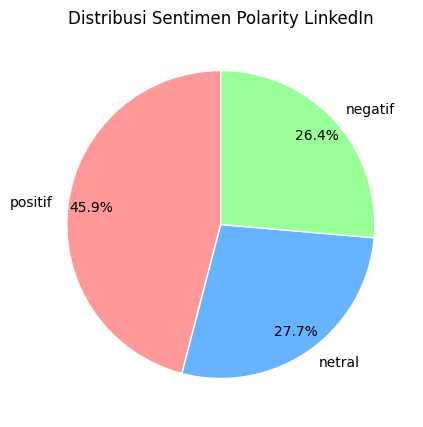

In [ ]:
polarity_counts = df['polarity'].value_counts()
polarity_labels = polarity_counts.index
polarity_sizes = polarity_counts.values
colors = ['#ff9999','#66b3ff','#99ff99']

plt.figure(figsize=(5,5))
plt.pie(polarity_sizes, labels=polarity_labels, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops={'edgecolor': 'white'}, pctdistance=0.85)
plt.title("Distribusi Sentimen Polarity LinkedIn")
plt.show()

In [ ]:
df

,content,score,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir,polarity_score,polarity
0,berasa tidak berfungsi...,2,berasa tidak berfungsi,berasa tidak berfungsi,berasa tidak berfungsi,"[berasa, tidak, berfungsi]","[berasa, berfungsi]",berasa berfungsi,-2,negatif
1,aplikasi gajelassss sering erorr,1,aplikasi gajelassss sering erorr,aplikasi gajelassss sering erorr,aplikasi gajelassss sering erorr,"[aplikasi, gajelassss, sering, erorr]","[aplikasi, gajelassss, erorr]",aplikasi gajelassss erorr,-4,negatif
2,lumayan bagus,5,lumayan bagus,lumayan bagus,lumayan bagus,"[lumayan, bagus]","[lumayan, bagus]",lumayan bagus,3,positif
3,"setelah update, malah ga bisa login. mohon dip...",1,setelah update malah ga bisa login mohon diper...,setelah update malah ga bisa login mohon diper...,setelah update malah ga bisa login mohon diper...,"[setelah, update, malah, ga, bisa, login, moho...","[update, login, mohon, diperbaiki, terima, kasih]",update login mohon diperbaiki terima kasih,6,positif
4,terimakasih atas aplikasinya semoga bermanfaat,5,terimakasih atas aplikasinya semoga bermanfaat,terimakasih atas aplikasinya semoga bermanfaat,terimakasih atas aplikasinya semoga bermanfaat,"[terimakasih, atas, aplikasinya, semoga, berma...","[terimakasih, aplikasinya, semoga, bermanfaat]",terimakasih aplikasinya semoga bermanfaat,10,positif
...,...,...,...,...,...,...,...,...,...,...
9993,sudah dimengerti,1,sudah dimengerti,sudah dimengerti,sudah dimengerti,"[sudah, dimengerti]",[dimengerti],dimengerti,0,netral
9994,Good information,5,Good information,good information,good information,"[good, information]","[good, information]",good information,5,positif
9995,Sangat bermanfaat untuk menunjang karier. 😊,5,Sangat bermanfaat untuk menunjang karier,sangat bermanfaat untuk menunjang karier,sangat bermanfaat untuk menunjang karier,"[sangat, bermanfaat, untuk, menunjang, karier]","[bermanfaat, menunjang, karier]",bermanfaat menunjang karier,2,positif
9998,Sangat bagus infonya,4,Sangat bagus infonya,sangat bagus infonya,sangat bagus infonya,"[sangat, bagus, infonya]","[bagus, infonya]",bagus infonya,2,positif


## Data Splitting and Feature Extraction using TF-IDF

In [ ]:
# Pisahkan data menjadi fitur (tweet) dan label (sentimen)
X = df['text_akhir']
y = df['polarity']

# Ekstraksi fitur dengan TF-IDF
tfidf = TfidfVectorizer(max_features=10000)
X_tfidf = tfidf.fit_transform(X)

# Konversi hasil ekstraksi fitur menjadi dataframe
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# Menampilkan hasil ekstraksi fitur
features_df

# Bagi data menjadi data latih dan data uji 80/20
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Bagi data menjadi data latih dan data uji 70/20
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)

In [ ]:
def preprocess_data(df):
    tokenizer = Tokenizer(num_words=7166, oov_token="<OOV>")
    tokenizer.fit_on_texts(df['text_akhir'])
    sequences = tokenizer.texts_to_sequences(df['text_akhir'])
    padded_sequences = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(df['polarity'])
    return padded_sequences, labels, tokenizer, label_encoder

padded_sequences, labels, tokenizer, label_encoder = preprocess_data(df)
X_train3, X_test3, y_train3, y_test3 = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
X_train4, X_test4, y_train4, y_test4 = train_test_split(padded_sequences, labels, test_size=0.3, random_state=42)

## Modeling using TF-IDF

### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Membuat objek model Random Forest
random_forest1 = RandomForestClassifier()
random_forest2 = RandomForestClassifier()

# Melatih model Random Forest pada data pelatihan
random_forest1.fit(X_train1.toarray(), y_train1)  # Skema 1 (80/20)
random_forest2.fit(X_train2.toarray(), y_train2)  # Skema 2 (70/30)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_rf1 = random_forest1.predict(X_train1.toarray())
y_pred_test_rf1 = random_forest1.predict(X_test1.toarray())

y_pred_train_rf2 = random_forest2.predict(X_train2.toarray())
y_pred_test_rf2 = random_forest2.predict(X_test2.toarray())

# Evaluasi akurasi model Random Forest
accuracy_train_rf1 = accuracy_score(y_train1, y_pred_train_rf1)
accuracy_test_rf1 = accuracy_score(y_test1, y_pred_test_rf1)

accuracy_train_rf2 = accuracy_score(y_train2, y_pred_train_rf2)
accuracy_test_rf2 = accuracy_score(y_test2, y_pred_test_rf2)

# Menyimpan hasil evaluasi dalam DataFrame
rf_score = pd.DataFrame({
    'Metric': ['Train Score 80/20', 'Test Score 80/20', 'Train Score 70/30', 'Test Score 70/30'],
    'Accuracy': [f"{accuracy_train_rf1 * 100:.2f}%", f"{accuracy_test_rf1 * 100:.2f}%", f"{accuracy_train_rf2 * 100:.2f}%", f"{accuracy_test_rf2 * 100:.2f}%"]
})

print(rf_score)

              Metric Accuracy
0  Train Score 80/20   99.98%
1   Test Score 80/20   83.33%
2  Train Score 70/30  100.00%
3   Test Score 70/30   82.65%


### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Membuat objek model Logistic Regression untuk masing-masing skema
logistic_regression1 = LogisticRegression()
logistic_regression2 = LogisticRegression()

# Melatih model Logistic Regression pada data pelatihan
logistic_regression1.fit(X_train1.toarray(), y_train1)  # Skema 80/20
logistic_regression2.fit(X_train2.toarray(), y_train2)  # Skema 70/30

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_lr1 = logistic_regression1.predict(X_train1.toarray())
y_pred_test_lr1 = logistic_regression1.predict(X_test1.toarray())

y_pred_train_lr2 = logistic_regression2.predict(X_train2.toarray())
y_pred_test_lr2 = logistic_regression2.predict(X_test2.toarray())

# Evaluasi akurasi model Logistic Regression
accuracy_train_lr1 = accuracy_score(y_train1, y_pred_train_lr1)
accuracy_test_lr1 = accuracy_score(y_test1, y_pred_test_lr1)

accuracy_train_lr2 = accuracy_score(y_train2, y_pred_train_lr2)
accuracy_test_lr2 = accuracy_score(y_test2, y_pred_test_lr2)

# Menyimpan hasil evaluasi dalam DataFrame
lr_score = pd.DataFrame({
    'Metric': ['Train Score 80/20', 'Test Score 80/20', 'Train Score 70/30', 'Test Score 70/30'],
    'Accuracy': [f"{accuracy_train_lr1 * 100:.2f}%",
                 f"{accuracy_test_lr1 * 100:.2f}%",
                 f"{accuracy_train_lr2 * 100:.2f}%",
                 f"{accuracy_test_lr2 * 100:.2f}%"]
})

# Menampilkan DataFrame
print(lr_score)

              Metric Accuracy
0  Train Score 80/20   94.78%
1   Test Score 80/20   84.52%
2  Train Score 70/30   94.70%
3   Test Score 70/30   83.95%


### Support Vector Classifier

In [ ]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Membuat objek model SVM untuk masing-masing skema
svm_model1 = SVC(kernel='linear')
svm_model2 = SVC(kernel='linear')

# Melatih model SVM pada data pelatihan
svm_model1.fit(X_train1, y_train1)  # Skema 80/20
svm_model2.fit(X_train2, y_train2)  # Skema 70/30

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_svm1 = svm_model1.predict(X_train1)
y_pred_test_svm1 = svm_model1.predict(X_test1)

y_pred_train_svm2 = svm_model2.predict(X_train2)
y_pred_test_svm2 = svm_model2.predict(X_test2)

# Evaluasi akurasi model SVM
accuracy_train_svm1 = accuracy_score(y_train1, y_pred_train_svm1)
accuracy_test_svm1 = accuracy_score(y_test1, y_pred_test_svm1)

accuracy_train_svm2 = accuracy_score(y_train2, y_pred_train_svm2)
accuracy_test_svm2 = accuracy_score(y_test2, y_pred_test_svm2)

# Menyimpan hasil evaluasi dalam DataFrame
svm_score = pd.DataFrame({
    'Metric': ['Train Score 80/20', 'Test Score 80/20', 'Train Score 70/30', 'Test Score 70/30'],
    'Accuracy': [f"{accuracy_train_svm1 * 100:.2f}%",
                 f"{accuracy_test_svm1 * 100:.2f}%",
                 f"{accuracy_train_svm2 * 100:.2f}%",
                 f"{accuracy_test_svm2 * 100:.2f}%"]
})

# Menampilkan DataFrame
print(svm_score)

              Metric Accuracy
0  Train Score 80/20   97.07%
1   Test Score 80/20   85.29%
2  Train Score 70/30   97.09%
3   Test Score 70/30   84.98%


### Convolutional Neural Network (CNN)

In [ ]:
cnn2 = Sequential([
        Embedding(7166, 64, input_length=100),
        Conv1D(64, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(16, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
])

cnn2.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

cnn2.fit(X_train3, y_train3, epochs=10)
cnn2_scores = cnn2.evaluate(X_test3, y_test3, batch_size=1)
print("Accuracy: %.2f%%" % (cnn2_scores[1]*100))

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.4611 - loss: 1.0236
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.7697 - loss: 0.6011
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8634 - loss: 0.3792
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9019 - loss: 0.2481
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9054 - loss: 0.2123
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9171 - loss: 0.1711
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9267 - loss: 0.1670
Epoch 8/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9271 - loss: 0.1500
Epoch 9/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9233 - loss: 0.1443
Epoch 10/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9283 - loss: 0.1334
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8533 - loss: 0.7302
Accuracy: 86.26%


In [ ]:
cnn = Sequential([
        Embedding(7166, 64, input_length=100),
        Conv1D(64, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(16, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
])

cnn.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

cnn.fit(X_train4, y_train4, epochs=10)
cnn_scores = cnn.evaluate(X_test4, y_test4, batch_size=1)
print("Accuracy: %.2f%%" % (cnn_scores[1]*100))

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.4765 - loss: 1.0203
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7885 - loss: 0.6004
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8857 - loss: 0.3932
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9175 - loss: 0.2469
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9456 - loss: 0.1691
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9575 - loss: 0.1500
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9637 - loss: 0.1197
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9613 - loss: 0.1208
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9585 - loss: 0.1084
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9630 - loss: 0.1049
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8607 - loss: 0.6519
Accuracy: 85.44%


### Gated Recurrent Unit (GRU)

In [ ]:
gru = Sequential([
    Embedding(input_dim=7166, output_dim=128, mask_zero=True),
    GRU(128, return_sequences=True),
    GRU(64),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  # 3 kelas sentimen (positif, negatif, netral)
])

gru.compile(loss='sparse_categorical_crossentropy',
            optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
            metrics=['accuracy'])

gru.fit(X_train4, y_train4, epochs=3)
gru_scores = gru.evaluate(X_test4, y_test4, batch_size=1)
print("Accuracy: %.2f%%" % (gru_scores[1]*100))

Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 50s 260ms/step - accuracy: 0.4803 - loss: 1.0014
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 39s 247ms/step - accuracy: 0.8777 - loss: 0.4721
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 38s 242ms/step - accuracy: 0.9542 - loss: 0.1950
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 66s 30ms/step - accuracy: 0.8567 - loss: 0.5483
Accuracy: 85.30%


# Inference

## CNN Model 1

In [ ]:
def cnn_predict_sentiment(text):
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=100, padding='post', truncating='post')
    prediction = cnn.predict(padded)
    sentiment = label_encoder.inverse_transform([np.argmax(prediction)])
    return sentiment[0]

In [ ]:
cnn_text = "Aplikasi paling ribet, gak jelas, gampangan ngari kerja di glints, lebih simpel, coba dong ubah seperti app glint"
print("Predicted Sentiment:", cnn_predict_sentiment(cnn_text))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Predicted Sentiment: negatif


## CNN Model 2

In [ ]:
def cnn2_predict_sentiment(text):
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=100, padding='post', truncating='post')
    prediction = cnn2.predict(padded)
    sentiment = label_encoder.inverse_transform([np.argmax(prediction)])
    return sentiment[0]

In [ ]:
cnn2_text = "Alhamdulillah seneng banget ada LinkedIn cari kerja lebih mudah, walaupun sampai saat ini belum ada panggilan 😭🥺 Semuanya, doakan Alda ya, supaya sebelum bulan puasa dapat panggilan kerja dan langsung keterima kerja, aaaminn☺️"
print("Predicted Sentiment:", cnn2_predict_sentiment(cnn2_text))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Predicted Sentiment: positif


## GRU Model

In [ ]:
def gru_predict_sentiment(text):
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=100, padding='post', truncating='post')
    prediction = gru.predict(padded)
    sentiment = label_encoder.inverse_transform([np.argmax(prediction)])
    return sentiment[0]

In [ ]:
gru_text = "Beranda LinkedIn saya sudah bermasalah sejak 2 bulan yang lalu, dimana beranda saya tidak menampilkan informasi apapun dengan pemberitahuan terjadi masalah, bahkan tetap seperti itu meski sudah saya reset dan install ulang aplikasi."
print("Predicted Sentiment:", gru_predict_sentiment(gru_text))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
Predicted Sentiment: negatif


## Random Forest Classifier

In [ ]:
def predict_sentiment_rf(text, vectorizer, model):
    # Transformasi teks ke dalam bentuk vektor yang sesuai
    text_vectorized = vectorizer.transform([text]).toarray()

    # Prediksi menggunakan model
    prediction = model.predict(text_vectorized)

    return prediction[0]

# Contoh teks untuk inference
sample_text = "sangat kecewa dengan LinkedIn. saya merasa tidak berlangganan premium sama sekali, tiba2 saldo di aplikasi dana saya di ambil dengan nominal yang cukup besar Rp. 1.116.078. saya sudah mencoba ajukan claim dana untuk di refund, tapi di tolak."

# Lakukan inference dengan model pertama (80/20) dan kedua (70/30)
pred_rf1 = predict_sentiment_rf(sample_text, tfidf, random_forest1)
pred_rf2 = predict_sentiment_rf(sample_text, tfidf, random_forest2)

# Output hasil prediksi
print(f"Predicted Sentiment (80/20 split): {pred_rf1}")
print(f"Predicted Sentiment (70/30 split): {pred_rf2}")

Predicted Sentiment (80/20 split): negatif
Predicted Sentiment (70/30 split): negatif


## Super Vector Classifier

In [ ]:
def predict_sentiment_svm(text, vectorizer, model):
    # Pastikan text dalam bentuk list, kemudian vektorisasi
    text_vectorized = vectorizer.transform([text]).toarray()

    # Prediksi sentimen
    prediction = model.predict(text_vectorized)

    return prediction[0]

# Contoh inference
sample_text = "Saya sebetulnya senang menggunakan aplikasi ini karena bisa berkoneksi dengan banyak profesional khususnya dalam mencari pekerjaan. Hanya saja agak kecewa ketika ada postingan yang berkaitan dengan pekerjaan tertentu di LinkedIn malah kena shadow ban. Saya harap tidak ada lagi kejadian serupa. #StopShadowBan"

# Pastikan vectorizer yang sama digunakan
pred_svm1 = predict_sentiment_svm(sample_text, tfidf, svm_model1)
pred_svm2 = predict_sentiment_svm(sample_text, tfidf, svm_model2)

print(f"Predicted Sentiment (SVM 80/20 split): {pred_svm1}")
print(f"Predicted Sentiment (SVM 70/30 split): {pred_svm2}")


Predicted Sentiment (SVM 80/20 split): positif
Predicted Sentiment (SVM 70/30 split): positif


## Logistic Regression

In [ ]:
def predict_sentiment_lr(text, vectorizer, model):
    text_vectorized = vectorizer.transform([text]).toarray()
    prediction = model.predict(text_vectorized)
    return prediction[0]

# Contoh inference dengan kedua model
sample_text = "Sangat membantu dalam mencari pekerjaan dan membangun relasi. informatif dan bermanfaat."

pred_lr1 = predict_sentiment_lr(sample_text, tfidf, logistic_regression1)
pred_lr2 = predict_sentiment_lr(sample_text, tfidf, logistic_regression2)

print(f"Predicted Sentiment (Logistic Regression 80/20): {pred_lr1}")
print(f"Predicted Sentiment (Logistic Regression 70/30): {pred_lr2}")

Predicted Sentiment (Logistic Regression 80/20): positif
Predicted Sentiment (Logistic Regression 70/30): positif
